<>:25: SyntaxWarning: invalid escape sequence '\~'
<>:25: SyntaxWarning: invalid escape sequence '\~'
/var/folders/s3/51rzg94s5318dvd1cr9t6cq40000gn/T/ipykernel_78857/1650303788.py:25: SyntaxWarning: invalid escape sequence '\~'
  plt.plot(z, p_values, color='red', label='$\~p(z)$')


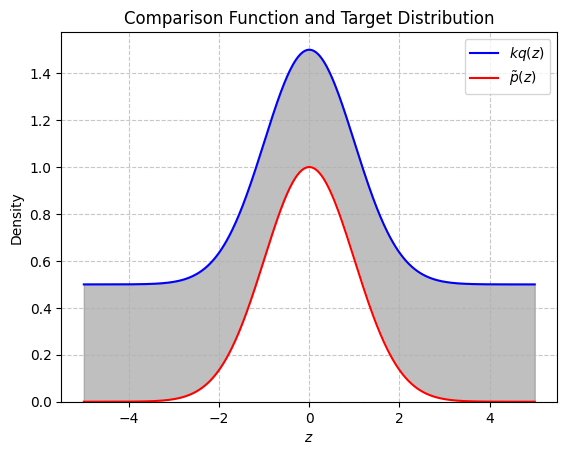

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison_and_target(kq, p, z_range):
    """
    Plot a comparison function kq and a target distribution p.
    
    Args:
        kq (function): The comparison function.
        p (function): The target distribution function.
        z_range (tuple): The range of z values as (z_min, z_max).
    """
    # Generate z values
    z = np.linspace(z_range[0], z_range[1], 500)
    
    kq_values = kq(z)
    p_values = p(z)
    
    # Plot the comparison function kq
    plt.fill_between(z, 0, kq_values, color='grey', alpha=0.5)
    plt.plot(z, kq_values, color='blue', label='$kq(z)$')
    
    # Plot the target distribution p
    plt.fill_between(z, 0, p_values, color='white')
    plt.plot(z, p_values, color='red', label='$\~p(z)$')
    
    plt.xlabel('$z$')
    plt.ylabel('Density')
    plt.title('Comparison Function and Target Distribution')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.ylim(bottom=0)
    
    plt.show()

# Example usage
def kq(z):
    return np.exp(-0.5 * (z)**2) + 0.5

def p(z):
    return np.exp(-0.5 * (z)**2)

plot_comparison_and_target(kq, p, z_range=(-5, 5))


In [52]:
def rejection_sampling(sample_size: int, p: callable, q: callable, kq: callable):
    """
    Rejection sampling algorithm.
    p is the unnormalized target distribution
    q is the proposal distribution
    kq is comparison function
    """
    samples = []
    while len(samples) < sample_size:
        z_0 = q()
        u_0 = np.random.uniform(0, kq(z_0))

        if u_0 <= p(z_0): # Acceptance condition
            samples.append(z_0)

    return np.array(samples)

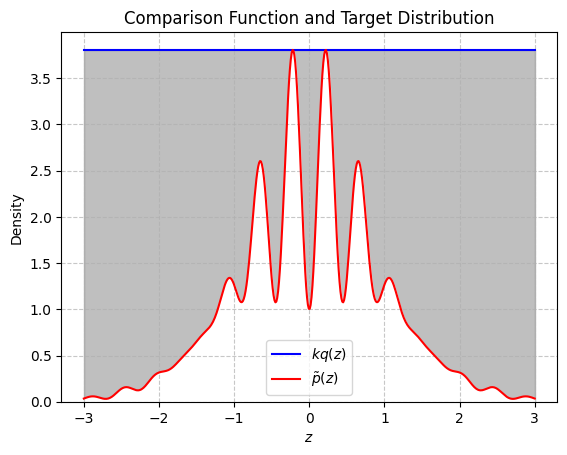

In [114]:
def p(x):
    return np.exp(-x**2 / 2) * (np.sin(x)**2 + 3 * np.cos(x)**2 * np.sin(7 * x)**2 + 1)

def uniform_proposal():
    return np.random.uniform(x_min, x_max)

def uniform_comparison(x):
    return np.full_like(x, max_val)

x_min, x_max = -3, 3
x_vals = np.linspace(x_min, x_max, 100000)
max_x = x_vals[np.argmax(p(x_vals))]
max_val = np.max(p(x_vals))

plot_comparison_and_target(uniform_comparison, p, (x_min, x_max))

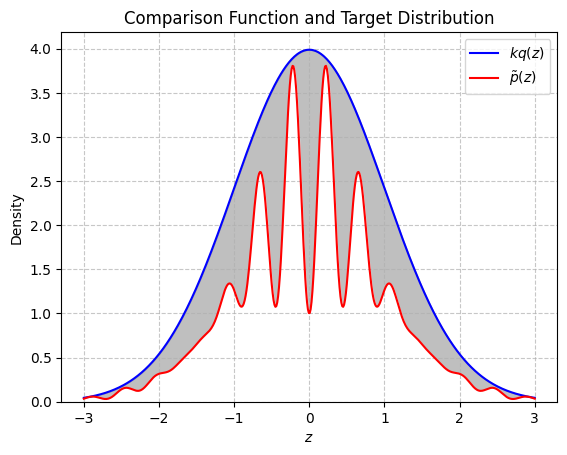

In [91]:
# Plot normal proposal and comparison
normal_mean = 0
normal_std = 1

def normal_pdf(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-(x - mean)**2 / (2 * std**2))

def normal_proposal():
    return np.random.normal(normal_mean, normal_std)

# Scale the normal PDF to encompass the maximum value of p(x)
scaling_factor = 10
# scaling_factor = 5*np.sqrt(2*np.pi)

def normal_comparison(x):
    return scaling_factor * normal_pdf(x, normal_mean, normal_std)

# Check that comparison function is larger than target distribution at all points
assert np.all(normal_comparison(x_vals) > p(x_vals)), "Comparison function is not larger than target distribution at all points"

plot_comparison_and_target(normal_comparison, p, (x_min, x_max))

{'Sample Size': [10, 100, 1000], 'Uniform Mean': [np.float64(0.9237820043825578), np.float64(0.9084217253261465), np.float64(0.9154128444040788)], 'Uniform Std': [np.float64(0.3988587064687571), np.float64(0.1301410062881639), np.float64(0.04170926047720912)], 'Normal Mean': [np.float64(0.9630287741776231), np.float64(0.9424417463009972), np.float64(0.9413378583177751)], 'Normal Std': [np.float64(0.45960790679214186), np.float64(0.13803602413072744), np.float64(0.04369789330612364)], 'Importance Mean': [np.float64(0.9386910923954366), np.float64(0.9470251639484993), np.float64(0.9418770279262184)], 'Importance Std': [np.float64(0.48046978524998996), np.float64(0.14988169314086686), np.float64(0.04544175433524399)]}


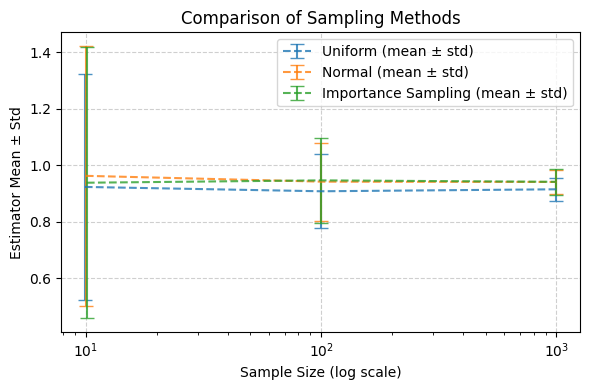

In [122]:
def importance_sampling_gaussian(sample_size, proposal_std=1):
    x = np.random.normal(0, proposal_std, sample_size)
    weights = p(x) / normal_pdf(x, 0, proposal_std)
    return x, weights

# Helper function for computing E[x^2] and its statistics
def compute_estimator(samples, weights=None):
    if weights is None:  # For rejection sampling
        return np.mean(samples**2)
    else:  # For importance sampling
        return np.sum(weights * samples**2) / np.sum(weights)

# Experiment settings
sample_sizes = [10, 100, 1000]
repeats = 1000  # Repeat each simulation for statistical stability

# Maximum densities for rejection sampling normalization
x_vals = np.linspace(x_min, x_max, 10000)
max_val = np.max(p(x_vals))

# Store results
results = {"Uniform": [], "Normal": [], "Importance Sampling": []}

# Run experiments
for sample_size in sample_sizes:
    uniform_means, normal_means, is_means = [], [], []
    for _ in range(repeats):
        # Uniform rejection sampling
        uniform_samples = rejection_sampling(sample_size, p, uniform_proposal, uniform_comparison)
        uniform_means.append(compute_estimator(uniform_samples))
        
        # Normal rejection sampling
        normal_samples = rejection_sampling(sample_size, p, normal_proposal, normal_comparison)
        normal_means.append(compute_estimator(normal_samples))
        
        # Importance sampling
        is_samples, is_weights = importance_sampling_gaussian(sample_size)
        is_means.append(compute_estimator(is_samples, is_weights))
    
    # Store results for mean and standard deviation
    results["Uniform"].append((np.mean(uniform_means), np.std(uniform_means)))
    results["Normal"].append((np.mean(normal_means), np.std(normal_means)))
    results["Importance Sampling"].append((np.mean(is_means), np.std(is_means)))

data = {
        "Sample Size": sample_sizes,
        "Uniform Mean": [r[0] for r in results["Uniform"]],
        "Uniform Std": [r[1] for r in results["Uniform"]],
        "Normal Mean": [r[0] for r in results["Normal"]],
        "Normal Std": [r[1] for r in results["Normal"]],
        "Importance Mean": [r[0] for r in results["Importance Sampling"]],
        "Importance Std": [r[1] for r in results["Importance Sampling"]],
    }

print(data)

plt.figure(figsize=(6, 4))
for i, method in enumerate(results.keys()):
    means = [r[0] for r in results[method]]
    stds = [r[1] for r in results[method]]
    
    # Slightly offset x positions for each method
    x_positions = np.array(sample_sizes) + (i - 1) * 0.1
    
    plt.errorbar(
        x_positions, means, yerr=stds, label=f"{method} (mean ± std)", capsize=5, alpha=0.8, linestyle='--'
    )

plt.xscale('log')
plt.xlabel('Sample Size (log scale)')
plt.ylabel('Estimator Mean ± Std')
plt.title('Comparison of Sampling Methods')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

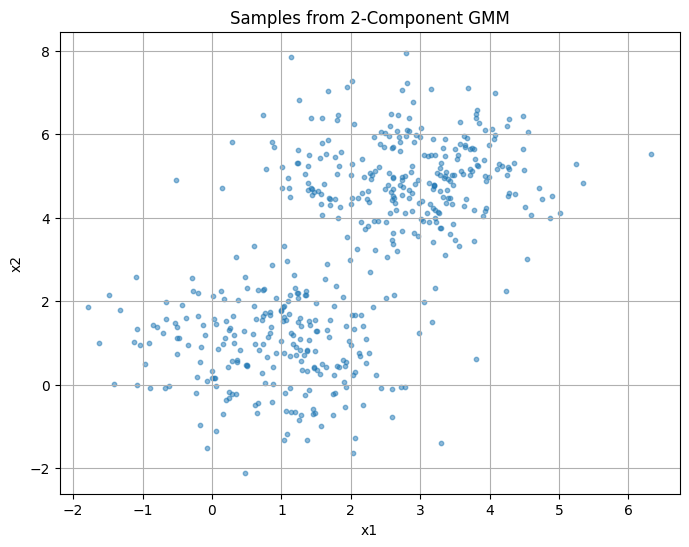

In [3]:
import pyro
import pyro.distributions as dist
import torch
import matplotlib.pyplot as plt

def gmm_model(n_samples):
    mixing_logits = torch.tensor([0.5, 0.5]).log()

    mu_1 = torch.tensor([1.0, 1.0])
    mu_2 = torch.tensor([3.0, 5.0])
    means = torch.stack([mu_1, mu_2])

    covariance = torch.eye(2).unsqueeze(0).expand(2, -1, -1)
    
    with pyro.plate("samples", n_samples):

        component = pyro.sample("component", dist.Categorical(logits=mixing_logits))
        
        selected_means = means[component]
        selected_covariance = covariance[component]
        
        samples = pyro.sample("samples", dist.MultivariateNormal(selected_means, selected_covariance))
    
    return samples

# Generate samples
n_samples = 500
samples = gmm_model(n_samples)

# Convert to numpy for plotting
samples_np = samples.numpy()

# Plot the samples
plt.figure(figsize=(8, 6))
plt.scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.5, s=10)
plt.title("Samples from 2-Component GMM")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()
